In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
def alpha_t(t):
    return t

def sigma_t(t):
    return 1 - t

def dalpha_dt(t):
    return torch.ones_like(t)

def dsigma_dt(t):
    return -torch.ones_like(t)

In [3]:
means = {
    1: np.array([-2, 0]),
    2: np.array([2, 0]),
    3: np.array([0, 2 * np.sqrt(3)])
}
cov = np.eye(2)

def sample_mixture(batch_size=1):
    y = np.random.choice([1, 2, 3], size=batch_size)
    x = np.array([np.random.multivariate_normal(mean=means[label], cov=cov) for label in y])

    return x, y

In [4]:
def sample_noise(batch_size=1):
    return np.random.normal(size=(batch_size, 2))

In [5]:
def sample_time(batch_size=1):
    return np.random.uniform(0, 1, size=(batch_size,))

In [6]:
class VectorFieldNN(nn.Module):
    def __init__(self, x_dim=2, y_num_classes=4, y_emb_dim=16, hidden_dim=256):
        super().__init__()
        self.y_embedding = nn.Embedding(num_embeddings=y_num_classes, embedding_dim=y_emb_dim)

        input_dim = x_dim + 1 + y_emb_dim  # x_t (2) + t (1) + y_emb (16)
        output_dim = x_dim  # u_t same dimension as x_t

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_t, t, y):
        y_emb = self.y_embedding(y)               # (batch_size, y_emb_dim)
        inp = torch.cat([x_t, t, y_emb], dim=-1)  # concatenate all inputs
        return self.net(inp)

In [7]:
batch_size = 256
num_steps = 5000
lr = 1e-3

model = VectorFieldNN(x_dim=2, y_num_classes=4, y_emb_dim=16, hidden_dim=256)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

def training_guided_flows(p_unconditional):
    for step in range(num_steps):
        # 1. Sample data
        x1, y = sample_mixture(batch_size = batch_size)
        x1_batch = torch.tensor(x1, dtype=torch.float32)

        # 2. Conditional or unconditional
        y_batch = torch.tensor(y, dtype=torch.long)  # shape (batch_size,)
        mask = torch.rand(batch_size) < p_unconditional  # True tamo gde želimo unconditional
        y_batch[mask] = 0  

        # 3. Sample noise and time
        x0 = sample_noise(batch_size=batch_size)
        x0_batch = torch.tensor(x0, dtype=torch.float32)
        t = sample_time(batch_size=batch_size)
        t_batch = torch.tensor(t, dtype=torch.float32).unsqueeze(1)

        # 4. Calculate x_t and dx/dt
        x_t = alpha_t(t_batch) * x1_batch + sigma_t(t_batch) * x0_batch      # shape (batch_size,2)
        dx_dt = dalpha_dt(t_batch) * x1_batch + dsigma_dt(t_batch) * x0_batch  # shape (batch_size,2)

        # 5. Forward pass
        u_t_pred = model(x_t, t_batch, y_batch)  # shape (batch_size, 2)

        # 6. Loss and optimization step
        loss = loss_fn(u_t_pred, dx_dt)  # MSE loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step + 1) % 500 == 0:
            print(f"Step {step+1}/{num_steps}, Loss: {loss.item():.6f}")

In [8]:
training_guided_flows(p_unconditional=0.1)

Step 500/5000, Loss: 1.911686
Step 1000/5000, Loss: 1.782513
Step 1500/5000, Loss: 1.750687
Step 2000/5000, Loss: 1.726359
Step 2500/5000, Loss: 1.705543
Step 3000/5000, Loss: 1.674318
Step 3500/5000, Loss: 1.591097
Step 4000/5000, Loss: 1.871186
Step 4500/5000, Loss: 1.484920
Step 5000/5000, Loss: 1.906256


In [9]:
def ode_step_rk4(model, x_t, t, h, y, w):
    with torch.no_grad():
        y0 = torch.tensor([0], dtype=torch.long)
        k1 = (1 - w) * model(x_t, t, y0) + w * model(x_t, t, y)
        k2 = (1 - w) * model(x_t + 0.5 * h * k1, t + 0.5 * h, y0) + w * model(x_t + 0.5 * h * k1, t + 0.5 * h, y)
        k3 = (1 - w) * model(x_t + 0.5 * h * k2, t + 0.5 * h, y0) + w * model(x_t + 0.5 * h * k2, t + 0.5 * h, y)
        k4 = (1 - w) * model(x_t + h * k3, t + h, y0) + w * model(x_t + h * k3, t + h, y)
        x_next = x_t + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [10]:
def sampling_from_guided_flows(model, y=0, w=1.0, num_steps=100):
    model.eval()
    with torch.no_grad():
        x0 = torch.tensor(sample_noise(batch_size=1), dtype=torch.float32)
        h = 1.0 / num_steps
        t = torch.zeros_like(x0[:, :1])
        x_t = x0.clone()

        for _ in range(num_steps):
            x_t = ode_step_rk4(model, x_t, t, h, torch.tensor([y], dtype=torch.long), w)
            t = t + h

    return x_t.squeeze(0).numpy()


In [11]:
n_samples = 400
data1 = []
for i in range(3):
    y = i + 1
    cluster = np.array([sampling_from_guided_flows(model, y=y, w=1.0, num_steps=100) for _ in range(n_samples)])
    data1.append(np.stack(cluster))

In [26]:
n_samples = 400
data2 = []
for i in range(3):
    y = i + 1
    cluster = np.array([sampling_from_guided_flows(model, y=y, w=4.0, num_steps=100) for _ in range(n_samples)])
    data2.append(np.stack(cluster))

In [22]:
n_samples = 400
data3 = []
for i in range(3):
    y = i + 1
    cluster = np.array([sampling_from_guided_flows(model, y=y, w=0.0, num_steps=100) for _ in range(n_samples)])
    data3.append(np.stack(cluster))

In [30]:
# def plot_density_field(points, cmap='binary', gridsize=200):
#     x, y = points[:, 0], points[:, 1]
#     xy = np.vstack([x, y])

#     # 1️⃣ Napravi KDE procenu gustine
#     kde = gaussian_kde(xy)

#     # 2️⃣ Napravi mrežu (grid) za celo područje
#     xmin, xmax = x.min(), x.max()
#     ymin, ymax = y.min(), y.max()
#     X, Y = np.mgrid[xmin:xmax:complex(gridsize), ymin:ymax:complex(gridsize)]
#     positions = np.vstack([X.ravel(), Y.ravel()])

#     # 3️⃣ Izračunaj gustinu u svakoj tački mreže
#     Z = np.reshape(kde(positions).T, X.shape)

#     # 4️⃣ Nacrtaj “toplotnu mapu” gustine
#     plt.figure(figsize=(6, 5))
#     plt.imshow(
#         np.rot90(Z),
#         cmap=cmap,
#         extent=[xmin, xmax, ymin, ymax],
#         aspect='auto'
#     )
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title('Glatka gustina tačaka (2D KDE)')
#     plt.show()

In [31]:
# plot_density_field(np.vstack(data2))

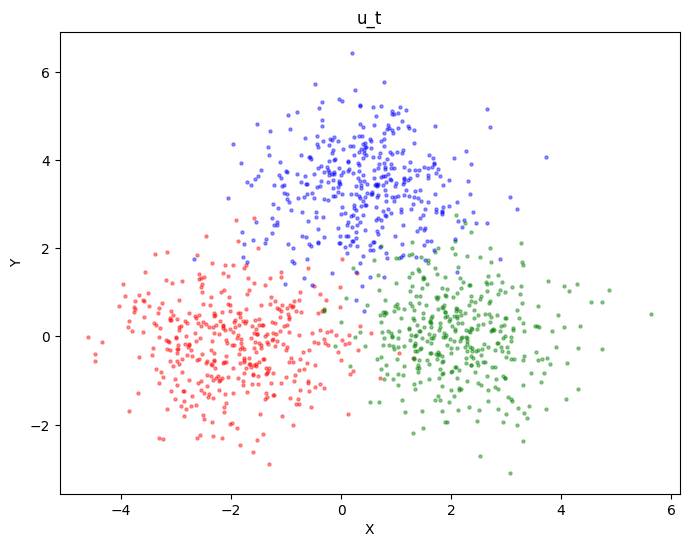

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
colors = ['Red', 'Green', 'Blue']

for i, cluster in enumerate(data1):
    # sns.kdeplot(
    #     x=cluster[:, 0], y=cluster[:, 1],
    #     fill=True,
    #     cmap=colors[i],
    #     bw_adjust=1.5,
    #     levels=100,
    #     thresh=0,
    #     alpha=0.3,     # prozirnost da se preklapaju
    #     label=f'Class {i+1}',
    #     cut = 0
    # )
    ax.scatter(
        cluster[:,0], cluster[:,1],
        s=5,                      # veličina tačke
        alpha=0.4,                # providnost (0.0 - 1.0)
        color=colors[i]
    )

plt.title("u_t")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

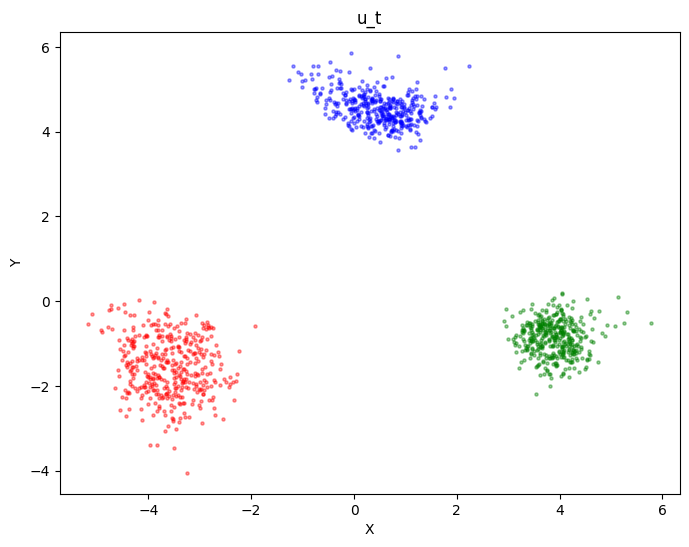

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
colors = ['Red', 'Green', 'Blue']

for i, cluster in enumerate(data2):
    # sns.kdeplot(
    #     x=cluster[:, 0], y=cluster[:, 1],
    #     fill=True,
    #     cmap=colors[i],
    #     bw_adjust=1.5,
    #     levels=100,
    #     thresh=0,
    #     alpha=0.3,     # prozirnost da se preklapaju
    #     label=f'Class {i+1}',
    #     cut = 0
    # )
    ax.scatter(
        cluster[:,0], cluster[:,1],
        s=5,                      # veličina tačke
        alpha=0.4,                # providnost (0.0 - 1.0)
        color=colors[i]
    )

plt.title("u_t")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

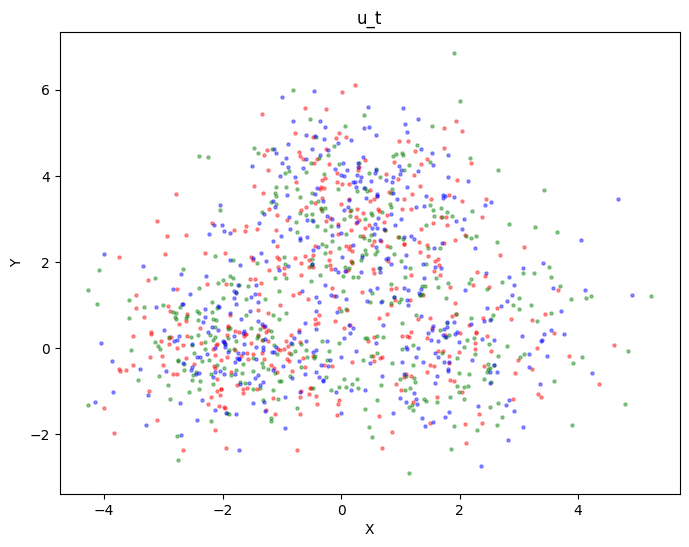

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
colors = ['Red', 'Green', 'Blue']

for i, cluster in enumerate(data3):
    # sns.kdeplot(
    #     x=cluster[:, 0], y=cluster[:, 1],
    #     fill=True,
    #     cmap=colors[i],
    #     bw_adjust=1.5,
    #     levels=100,
    #     thresh=0,
    #     alpha=0.3,     # prozirnost da se preklapaju
    #     label=f'Class {i+1}',
    #     cut = 0
    # )
    ax.scatter(
        cluster[:,0], cluster[:,1],
        s=5,                      # veličina tačke
        alpha=0.4,                # providnost (0.0 - 1.0)
        color=colors[i]
    )

plt.title("u_t")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()